In [ ]:
#Note tried to do some something new with hypertuning for this dataset just to learn

In [ ]:
#Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import colorlover as cl
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn import metrics

In [ ]:
df = pd.read_csv("SkillCraft.csv")
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [ ]:
df.shape

(3338, 20)

In [ ]:
df.dtypes

GameID                    int64
LeagueIndex               int64
Age                       int64
HoursPerWeek              int64
TotalHours                int64
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [ ]:
df.drop(columns=["Age", "HoursPerWeek", "TotalHours"], inplace=True)

In [ ]:
print("Number of missing value for each feature:")
print(df.isnull().sum())

Number of missing value for each feature:
GameID                  0
LeagueIndex             0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64


In [ ]:
df.describe()

,GameID,LeagueIndex,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000
mean,4719.552127,4.120731,114.575763,0.004023,0.000364,4.316357,0.000094,0.000380,0.003433,40.713819,64.209584,5.266955,22.116836,0.001031,6.541043,0.000060,0.000142
std,2656.919630,1.448170,48.111912,0.004726,0.000210,2.333322,0.000159,0.000359,0.000966,17.057191,19.037394,1.500605,7.440875,0.000520,1.859049,0.000112,0.000266
min,52.000000,1.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2423.250000,3.000000,79.231500,0.001245,0.000202,3.000000,0.000000,0.000139,0.002743,29.326600,50.886425,4.261525,17.000000,0.000682,5.000000,0.000000,0.000000
50%,4788.000000,4.000000,107.070300,0.002445,0.000349,4.000000,0.000039,0.000278,0.003376,37.058900,61.296100,5.087050,22.000000,0.000904,6.000000,0.000000,0.000020
75%,6994.750000,5.000000,140.156100,0.004945,0.000493,6.000000,0.000113,0.000508,0.004003,48.510425,74.032525,6.027350,27.000000,0.001258,8.000000,0.000087,0.000182
max,9271.000000,7.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [ ]:
#Data Exploration

%matplotlib inline

# Name the leagues
league_lbls = ["Bronze","Silver","Gold","Platinum","Diamond","Master","Grandmaster"]
league_indexs = df["LeagueIndex"].unique()
league_indexs.sort()
league_lbls_dict = dict()
for i, ind in enumerate(league_indexs):
    league_lbls_dict[ind] = league_lbls[i]
league_labeled = df["LeagueIndex"].replace(league_lbls_dict)

def clrgb_to_hex(rgb):
    rgb = re.search("\(([^\)]+)\)", rgb).group(1).split(",")
    hex_clr = "#"
    for n in rgb:
        val = hex(int(n))[2:]
        if len(val)<2:
            val = "0"+val
        hex_clr+=val
    return hex_clr

# Define league colours for consistency
league_colours_raw = cl.scales['8']['qual']['Paired']
league_colours = []
for i, clr in enumerate(league_colours_raw):
    league_colours.append(clrgb_to_hex(league_colours_raw[i]))

league_colours_dict = dict()
for i, lbl in enumerate(league_lbls):
    league_colours_dict[lbl] = league_colours[i]

def box_hist_plot(x, title, w, h):
    fig, (ax_box, ax_hist)= plt.subplots(2, sharex=True,gridspec_kw={"height_ratios": (.15,.85)})
    fig.set_size_inches(w, h)
    
    ax_box.set_xlim(0,x.max())
    ax_hist.set_xlim(0,x.max())
    
    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist)
    ax_box.set(yticks=[])
    
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_box.set_title(title)
    ax_hist.set_title(None)
    plt.show()
    
def violin_plot(y, title, w, h):
    plt.figure(figsize=(w, h))
    ax1 = sns.violinplot(x=league_labeled, y=y, palette=league_colours_dict, order=league_lbls)
    ax1.set_ylim(0,)
    ax1.set(xlabel='League')
    plt.title(title)
    plt.show()
    
def auto_plot(feature, fig_num):
    box_hist_plot(df[feature], f"Figure {fig_num}: {feature} Distribution", 11, 8)
    violin_plot(df[feature], f"Figure {fig_num+1}: {feature} by League", 11, 8)


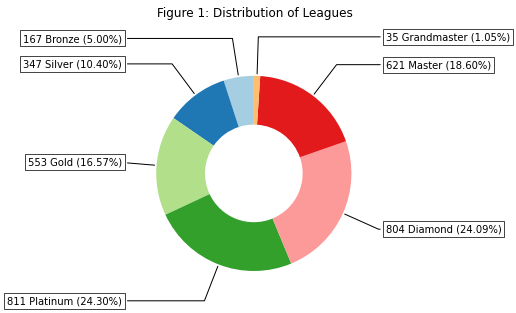

In [ ]:
def league_dist():
    global fig_count
    
    #labels
    lab = league_lbls
    #values: counts for each category
    val = df["LeagueIndex"].value_counts().sort_index().values.tolist()
    pct = [x/sum(val)for x in val]
    
    fig1, ax1 = plt.subplots()
    #ax1.pie(val, labels=lab, autopct='%1.2f%%', pctdistance=0.8,shadow=True, startangle=90)
    
    wedges, texts = ax1.pie(pct, wedgeprops=dict(width=0.5), startangle=90, colors=league_colours)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax1.annotate(f"{val[i]} {league_lbls[i]} ({pct[i]*100:.2f}%)", xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y), horizontalalignment=horizontalalignment, **kw)
        ax1.set_title("Figure 1: Distribution of Leagues", y=1.2)
    
league_dist()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


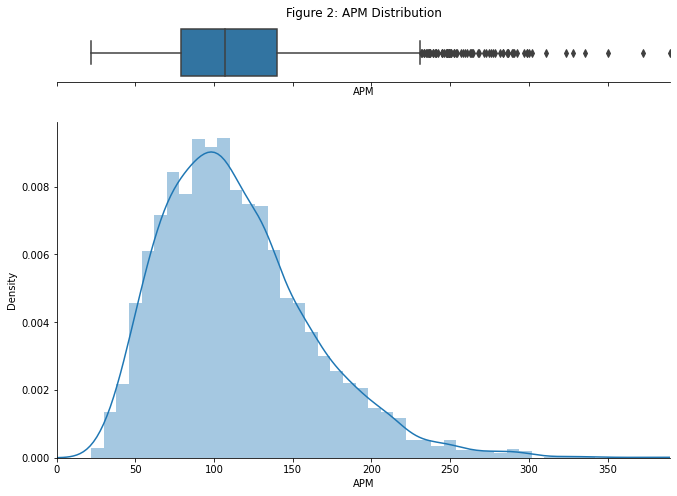

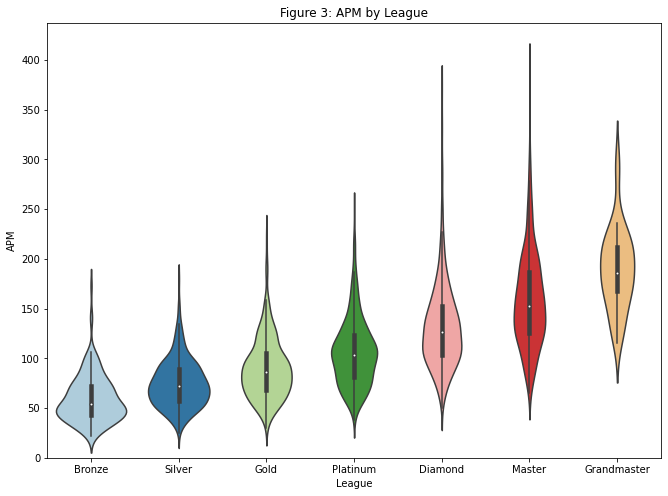

In [ ]:
#Data Visualization

auto_plot("APM",2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


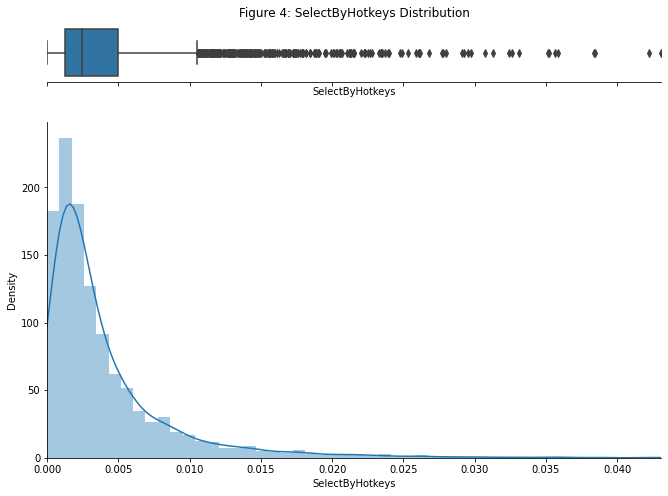

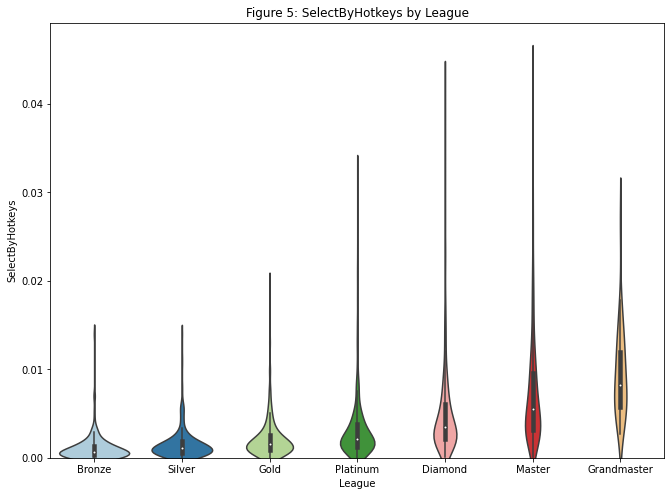

In [ ]:
auto_plot("SelectByHotkeys",4)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


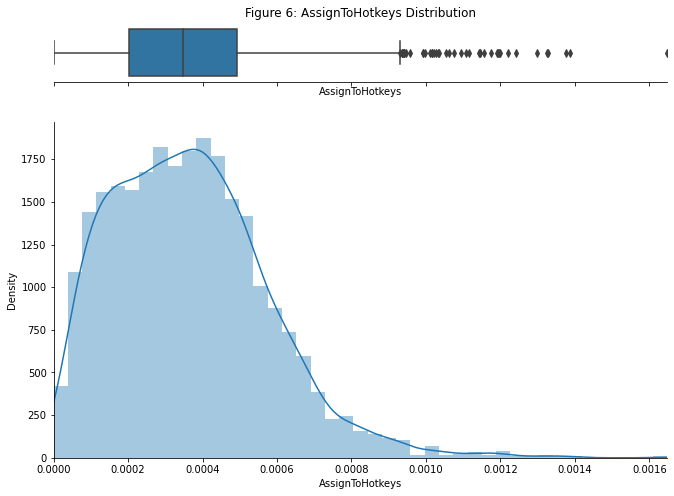

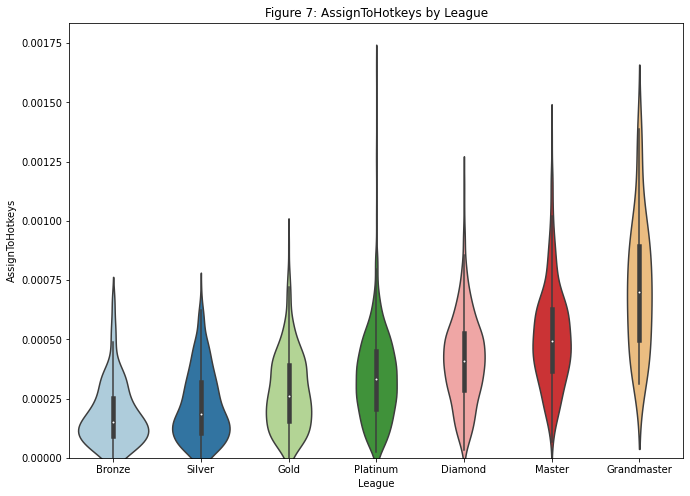

In [ ]:
auto_plot("AssignToHotkeys",6)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


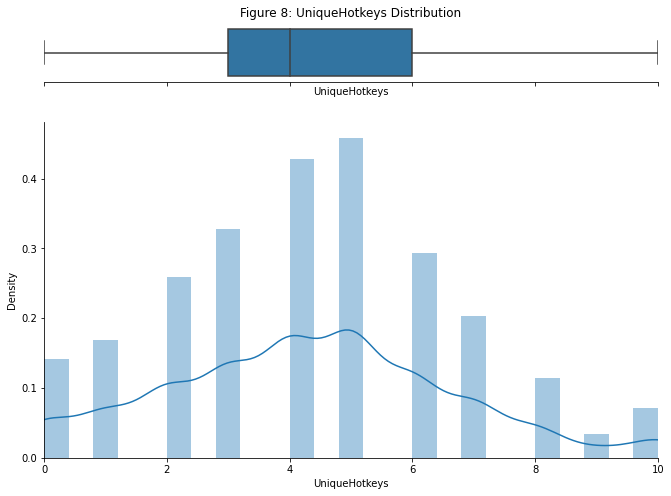

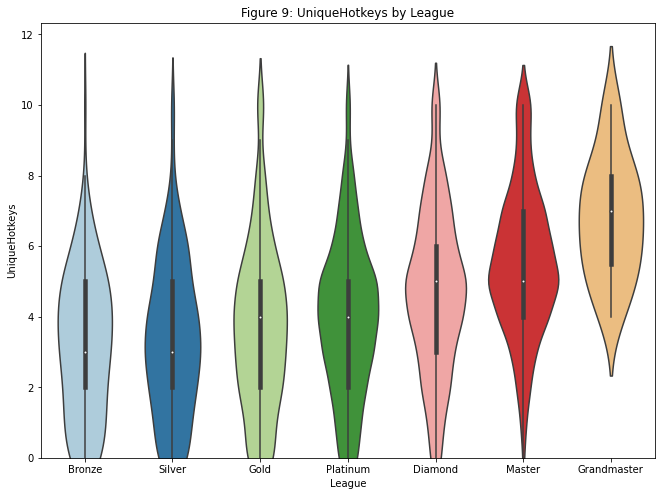

In [ ]:
auto_plot("UniqueHotkeys",8)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


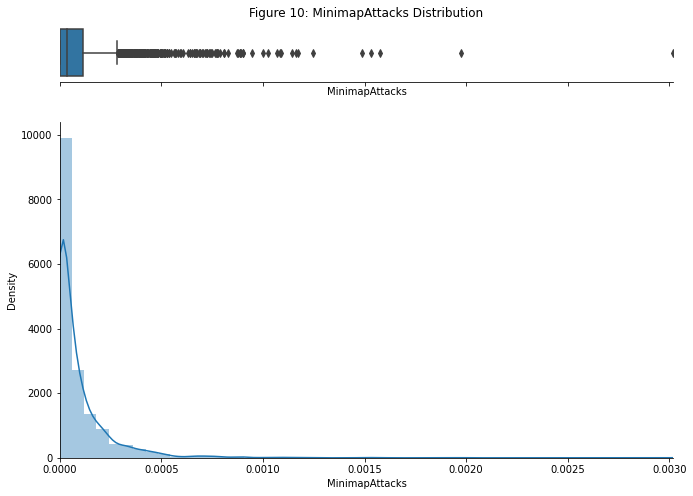

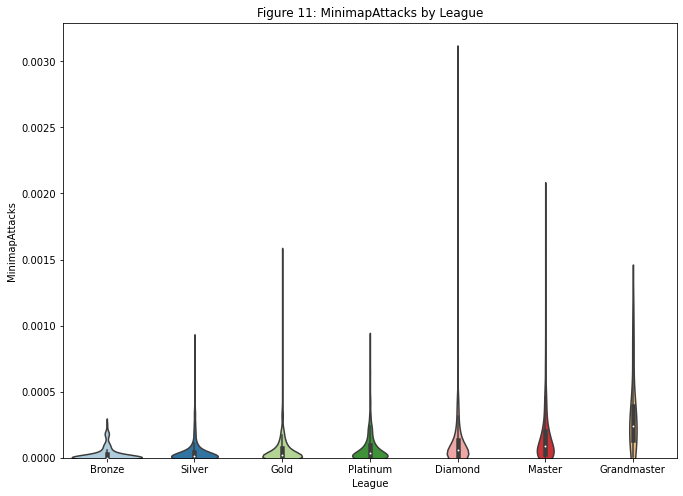

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


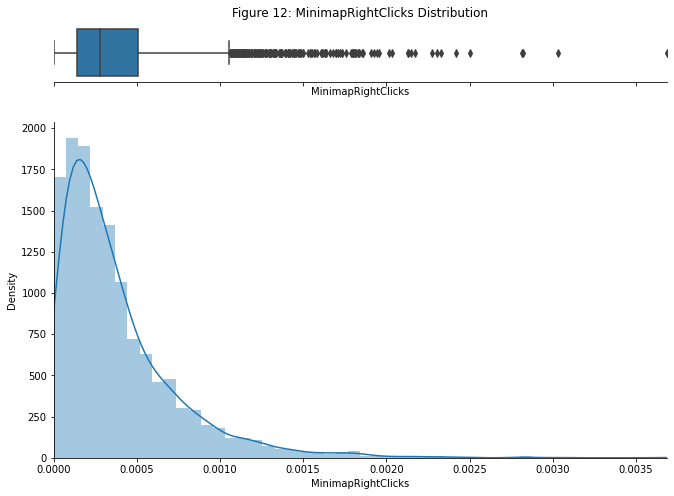

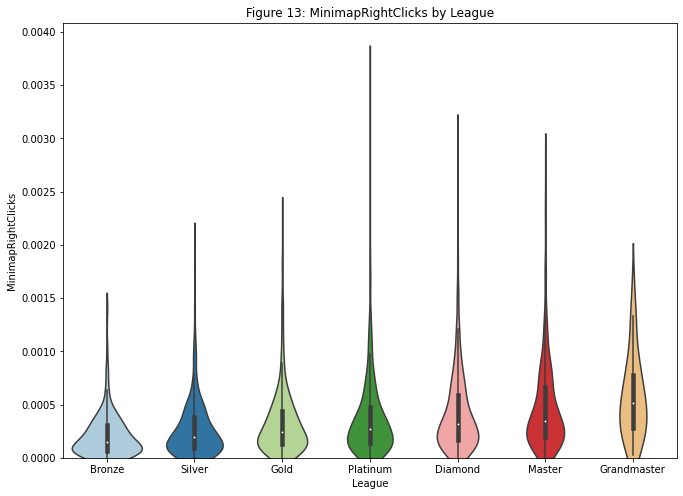

In [ ]:
auto_plot("MinimapAttacks",10)
auto_plot("MinimapRightClicks",12)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


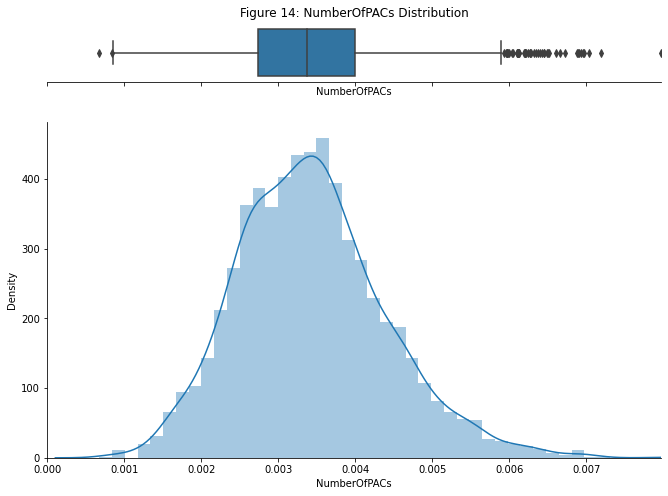

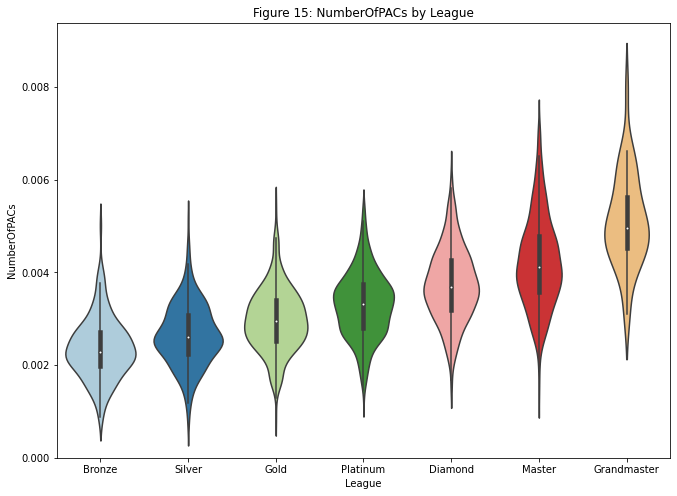

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


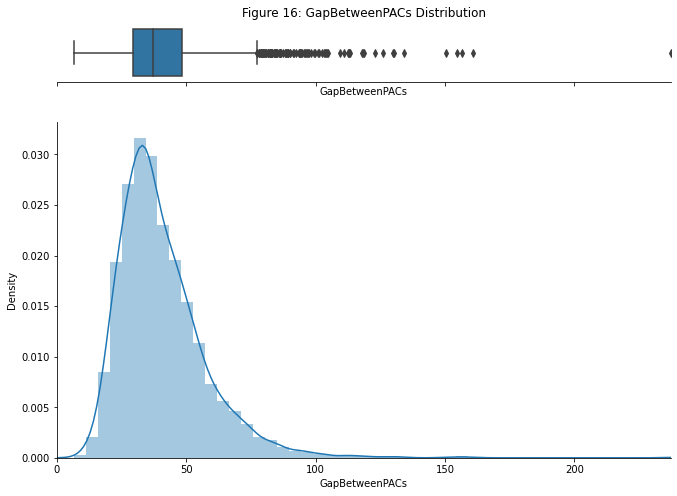

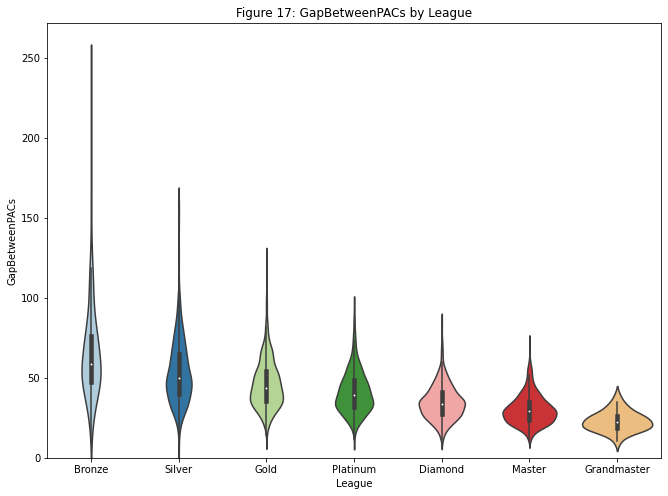

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


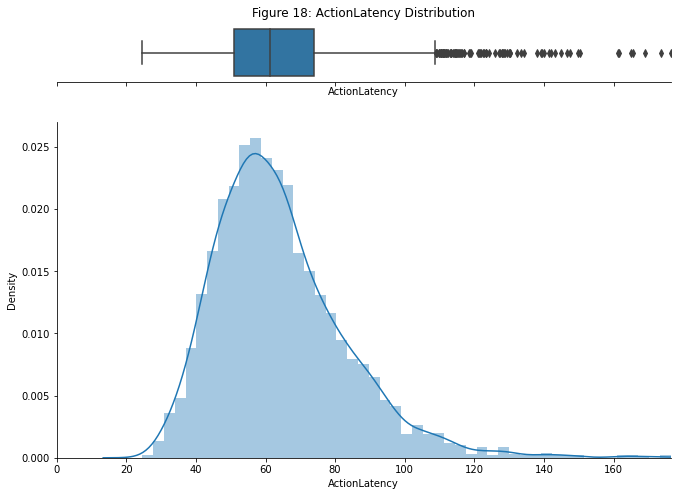

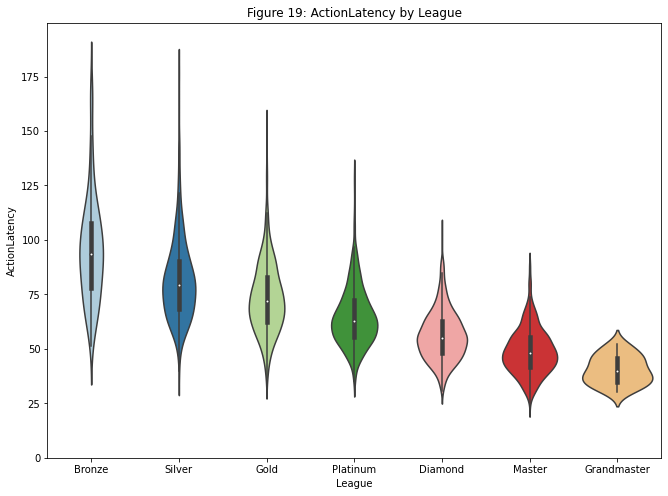

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


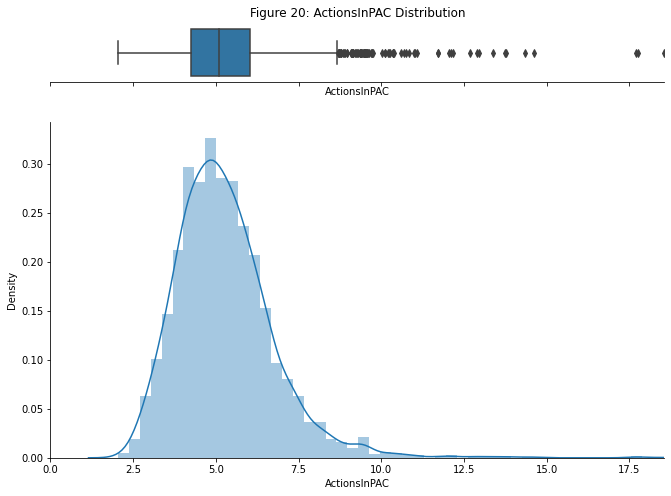

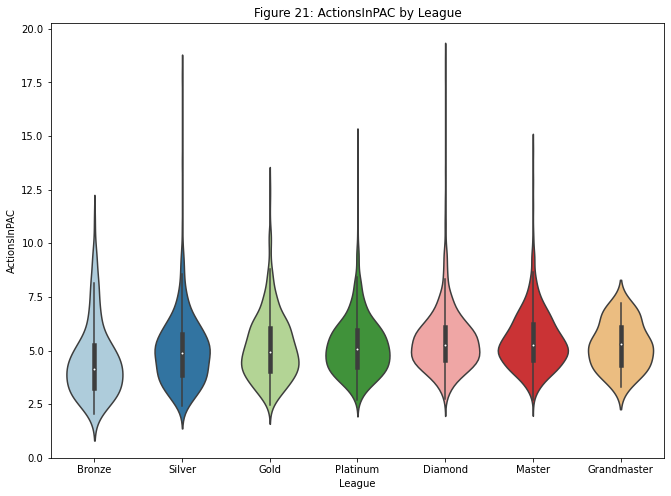

In [ ]:
auto_plot("NumberOfPACs",14)
auto_plot("GapBetweenPACs",16)
auto_plot("ActionLatency",18)
auto_plot("ActionsInPAC",20)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


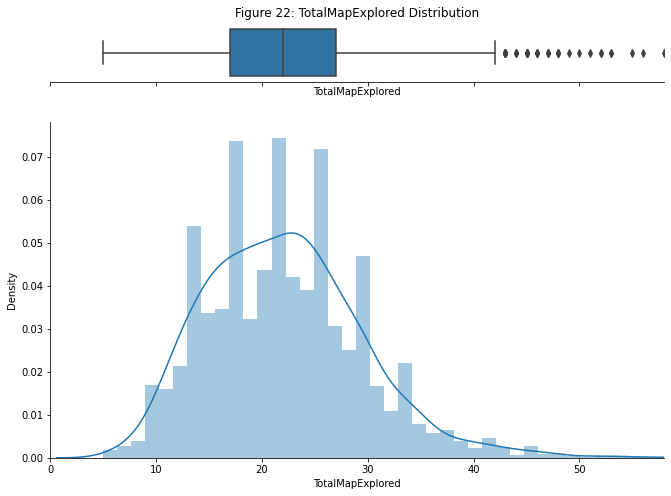

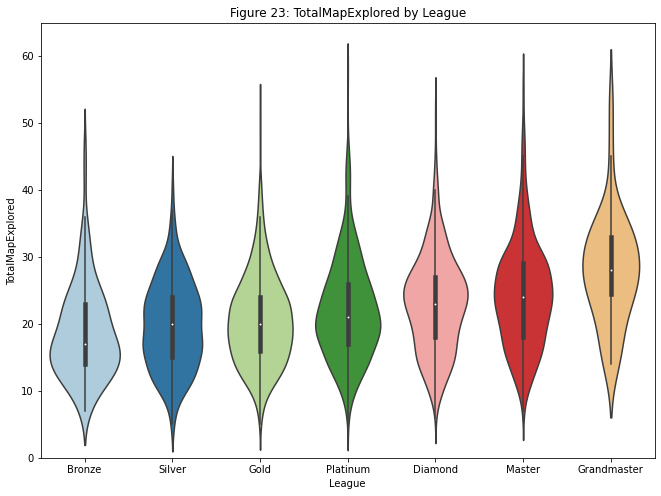

In [ ]:
auto_plot("TotalMapExplored",22)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


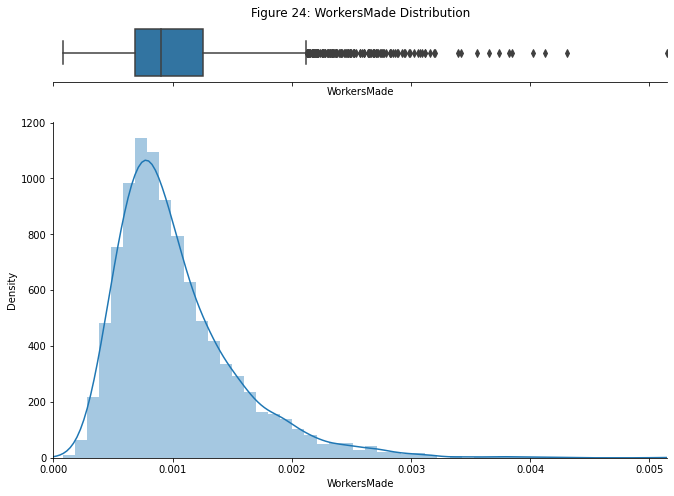

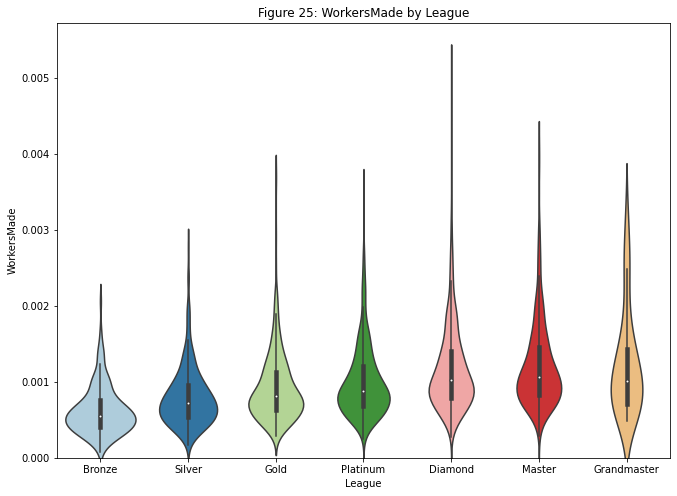

In [ ]:
auto_plot("WorkersMade",24)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


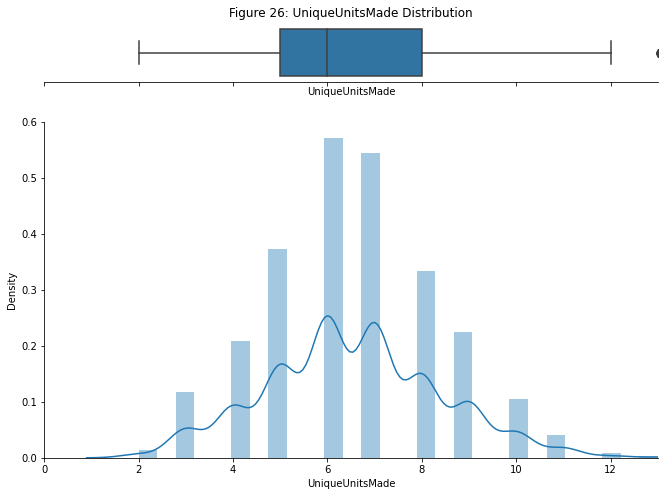

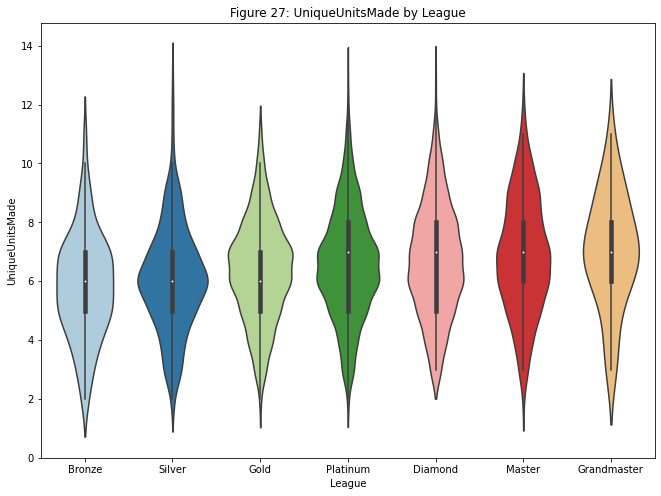

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


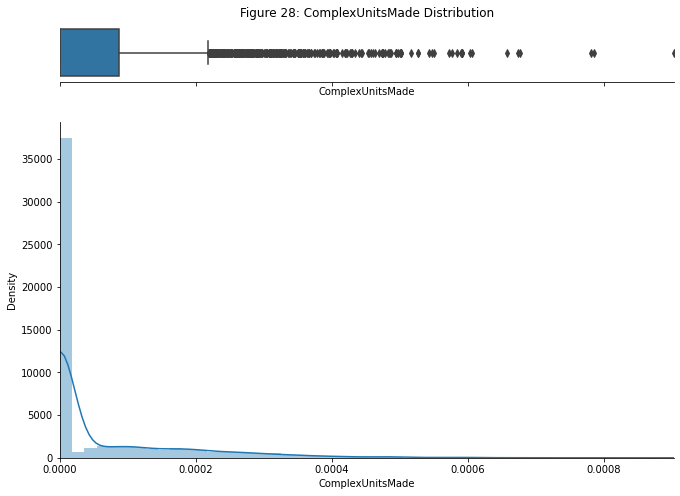

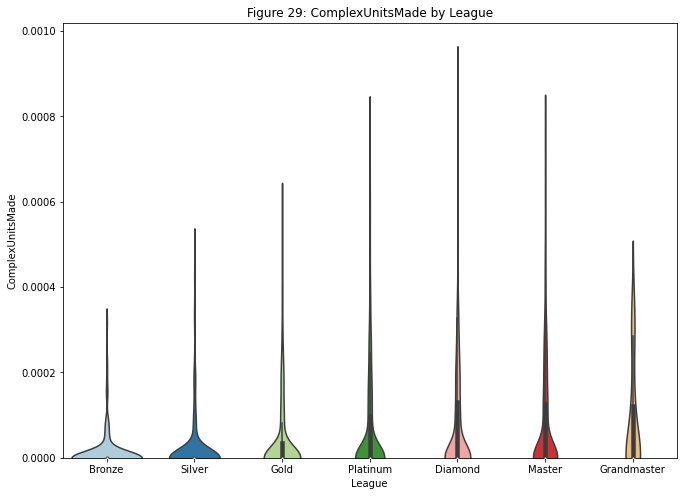

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


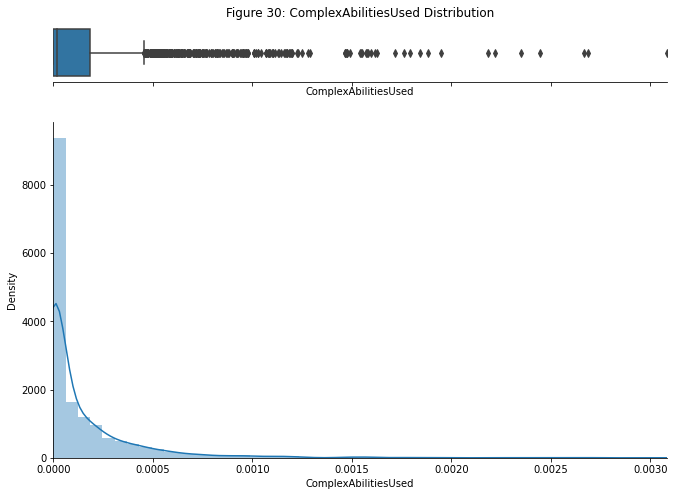

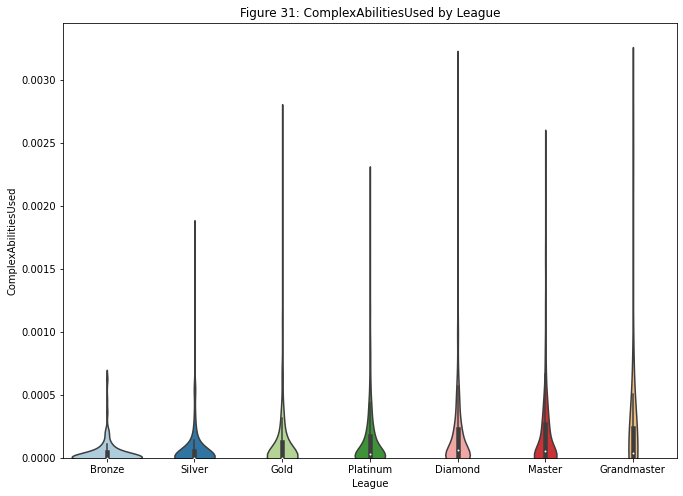

In [ ]:
auto_plot("UniqueUnitsMade",26)
auto_plot("ComplexUnitsMade",28)
auto_plot("ComplexAbilitiesUsed",30)

In [ ]:
#Data Preparation

leagues = df.LeagueIndex
df_data = df.drop(columns='LeagueIndex')
leagues.value_counts()

4    811
5    804
6    621
3    553
2    347
1    167
7     35
Name: LeagueIndex, dtype: int64

In [ ]:
# Reencode
leagues.replace({2:1, 3:2, 4:3, 5:4, 6:5, 7:5, 8:5}, inplace=True)
# New Value Counts
leagues.value_counts()

3    811
4    804
5    656
2    553
1    514
Name: LeagueIndex, dtype: int64

In [ ]:
def normalize_data(data):
    scaler = preprocessing.MinMaxScaler()
    data_norm = scaler.fit_transform(data)
    
    # When the data has been transformed, a np.array is returned,
    # So we have to convert it back to a dataframe, and insert column names
    return pd.DataFrame(data_norm, columns=data.columns)
    
df_norm = normalize_data(df_data)
df_norm.describe()

,GameID,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000
mean,0.506297,0.251559,0.093373,0.220924,0.431636,0.031060,0.103112,0.377758,0.147725,0.260822,0.195412,0.322959,0.188085,0.412822,0.066481,0.046027
std,0.288200,0.130820,0.109691,0.127417,0.233332,0.052654,0.097485,0.132421,0.074008,0.125461,0.090840,0.140394,0.102589,0.169004,0.123587,0.086145
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.257213,0.155455,0.028890,0.122387,0.300000,0.000000,0.037644,0.283059,0.098318,0.173019,0.134548,0.226415,0.119247,0.272727,0.000000,0.000000
50%,0.513722,0.231151,0.056747,0.211547,0.400000,0.012798,0.075495,0.369924,0.131867,0.241621,0.184522,0.320755,0.163091,0.363636,0.000000,0.006626
75%,0.753091,0.321114,0.114759,0.299012,0.600000,0.037571,0.137644,0.455923,0.181553,0.325557,0.241443,0.415094,0.232930,0.545455,0.096887,0.059123
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


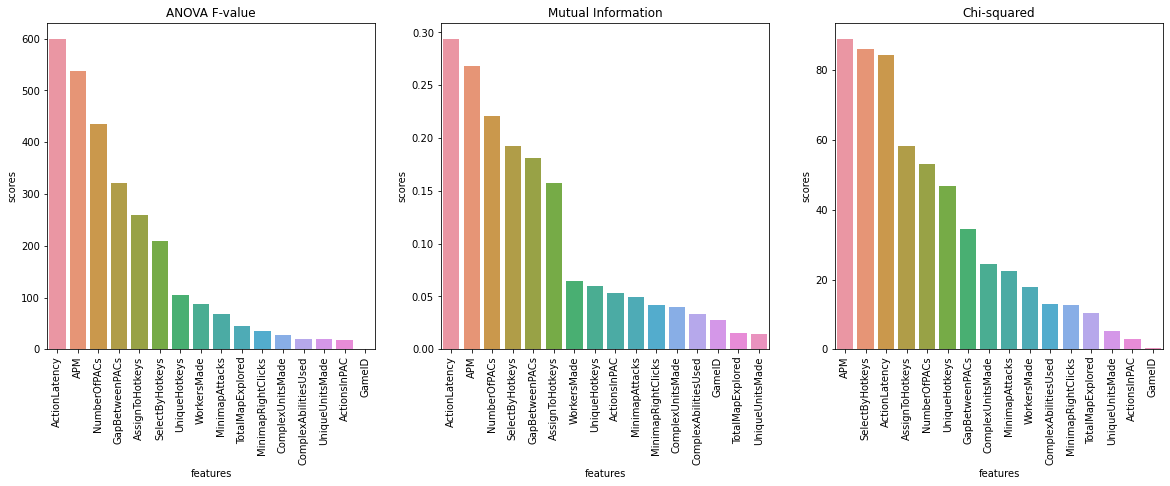

In [ ]:
#Feature selection and ranking

def plot_scores():
    def get_k_best(data, target, method, k):
        skb = SelectKBest(method, k = k)
        skb.fit(data.values, target.values)
        fs_indices = np.argsort(skb.scores_)[::-1]

        return pd.DataFrame({"features": data.columns[fs_indices].values, 
                      "scores": skb.scores_[fs_indices]})
    
    fig, axs = plt.subplots(ncols=3, figsize=(20,6))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    
    titles = []
    data = []
    titles.append("ANOVA F-value")
    data.append(get_k_best(df_norm, leagues, f_classif, len(df_norm.columns)))
    titles.append("Mutual Information")
    data.append(get_k_best(df_norm, leagues, mutual_info_classif, len(df_norm.columns)))
    titles.append("Chi-squared")
    data.append(get_k_best(df_norm, leagues, chi2, len(df_norm.columns)))
    
    for i in range(3):
        p = sns.barplot(x='features', y='scores', data=data[i], ax=axs[i])
        p.set_xticklabels(p.get_xticklabels(), rotation=90)
        p.set_title(titles[i])
plot_scores()

In [ ]:
df_train, df_test, leagues_train, leagues_test = train_test_split(df_norm, leagues, test_size = 0.3, random_state=1, stratify = leagues)

print(f"Training dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")
print(f"Training target shape: {leagues_train.shape}")
print(f"Test target shape: {leagues_test.shape}")

Training dataset shape: (2336, 16)
Test dataset shape: (1002, 16)
Training target shape: (2336,)
Test target shape: (1002,)


In [ ]:
#Model Evaluation Strategy

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

Hypertuning
KNN

Here we will stack feature selection and grid search for hyperparameter tuning (via cross-validation) in a "pipeline". The same Pipieline methodology will be used for NB and DT. Our pipeline will include multiple selectors, which were discussed in the Feature Selection and Ranking section.

KNN hyperparameters include:

The number of neighbours, where we will initially consider n of 150, 160 ,170 ,180 ,190, and 200.

The distance metric p, where we will initially consider p values of 1 (Manhattan), 2 (Euclidean), and 5 (Minkowski)

In [ ]:
#Hypertuning
#KNN

def run_KNN_pipe(n_neighbours, p):
    pipe_KNN = Pipeline([('selector', SelectKBest()), ('knn', KNeighborsClassifier())])

    params_pipe_KNN = {'selector__score_func': [f_classif, mutual_info_classif, chi2], 'selector__k': [3, 4, 5, 6, 7, 10, df_norm.shape[1]], 'knn__n_neighbors': n_neighbours, 'knn__p': p}

    gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, param_grid=params_pipe_KNN, cv=cv, n_jobs = -1, scoring='accuracy', verbose=0)

    gs_pipe_KNN.fit(df_train, leagues_train);
    
    return gs_pipe_KNN

gs_pipe_KNN = run_KNN_pipe([150, 160 ,170 ,180 ,190, 200], [1,2,5])

In [ ]:
gs_pipe_KNN.best_params_

{'knn__n_neighbors': 160,
 'knn__p': 2,
 'selector__k': 5,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif>}

In [ ]:
gs_pipe_KNN.best_score_

0.4409219300011592

In [ ]:
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head(5)

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,selector__k,selector__score_func
90,0.440922,0.0212266,0.480769,0.398287,160,2,5,<function f_classif at 0x7f5327e56e60>
69,0.440496,0.0218238,0.477516,0.400428,160,1,5,<function f_classif at 0x7f5327e56e60>
27,0.438637,0.0236061,0.49359,0.398287,150,2,5,<function f_classif at 0x7f5327e56e60>
132,0.438354,0.0248074,0.486081,0.38758,170,1,5,<function f_classif at 0x7f5327e56e60>
195,0.438352,0.0228614,0.485043,0.394004,180,1,5,<function f_classif at 0x7f5327e56e60>


We will plot these expected results to get an understanding of how changing the hyperparameters affect the prediction accuracy.

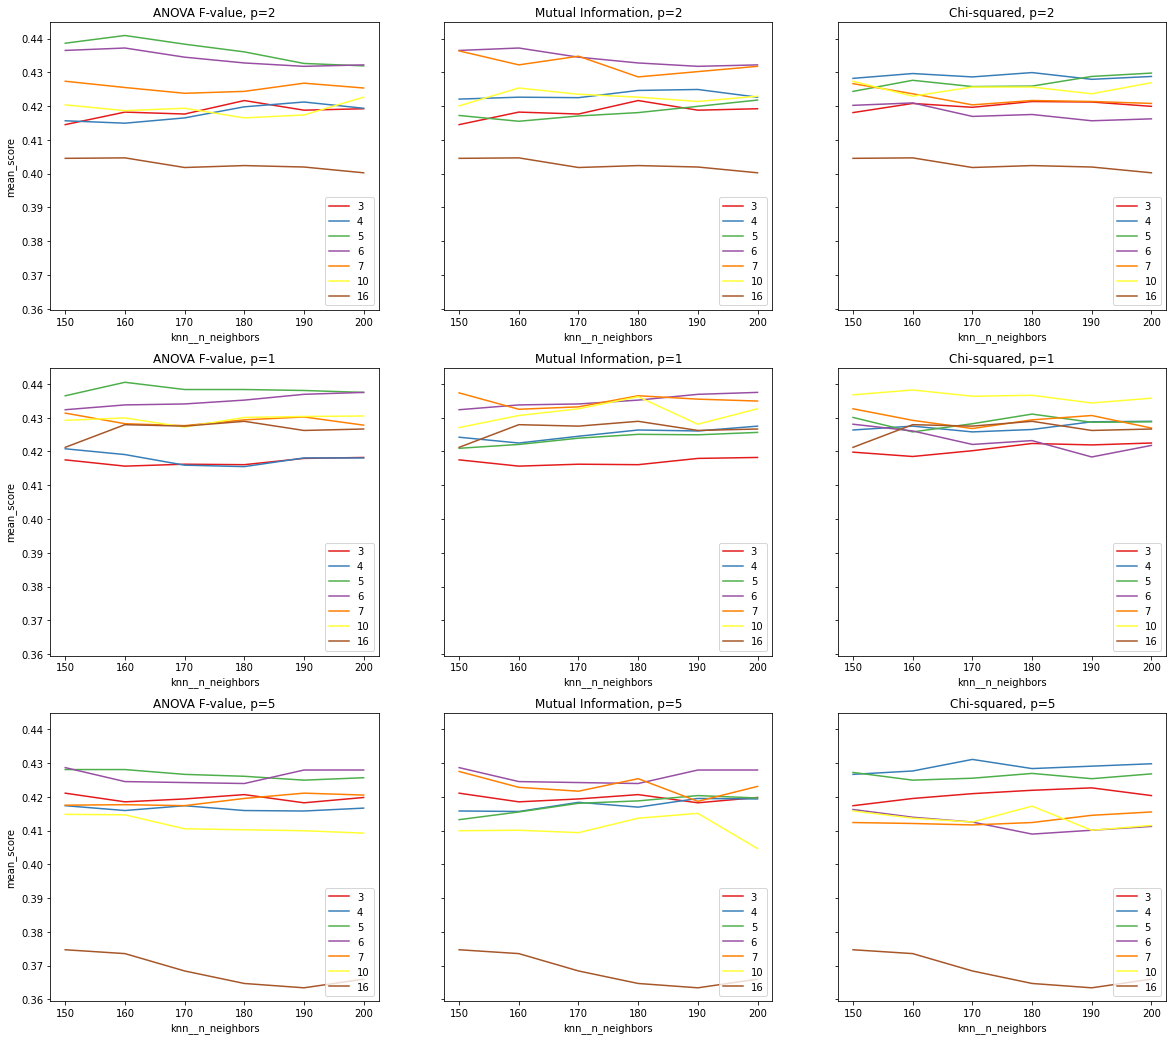

In [ ]:
def plot_KNN_results(res):
    def get_selector_data(d, p, sel):
        return d[(d.knn__p==p) & (d.selector__score_func==sel)].iloc[:,[0,4,6]]
    
    rows = len(res["knn__p"].unique())
    
    fig, axs = plt.subplots(ncols=3, nrows=rows, figsize=(20,rows*6), sharey='all')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
    titles = []
    data = []
    temp = res.copy().infer_objects()
    for i, p in enumerate(res["knn__p"].unique()):
        titles.append(f"ANOVA F-value, p={p}")
        data.append(get_selector_data(temp, p, f_classif))
        titles.append(f"Mutual Information, p={p}")
        data.append(get_selector_data(temp, p, mutual_info_classif))
        titles.append(f"Chi-squared, p={p}")
        data.append(get_selector_data(temp, p, chi2))
    
    row = 0
    col = 0
    ax = None
    for i in range(rows*3):
        if col%3==0 and col!=0:
            col=0
            row+=1
        if rows == 1:
            ax = axs[col]
        else:
            ax=axs[row,col]
        p = sns.lineplot(x='knn__n_neighbors', 
                         y='mean_score', 
                         hue='selector__k', 
                         data=data[i], 
                         ax=ax, 
                         palette=sns.color_palette("Set1", 7))
        p.set_title(titles[i])
        p.legend(loc='lower right')
        col+=1
        
plot_KNN_results(results_KNN)

KNN Fine Tuning
We can see in the graphs that many of the lines are trending upward as we increase our n value, so we will rerun the pipeline with higher values to compare. Because p=1 is the best performing value for p in general, we will stick with that for this new run.

In [ ]:
gs_pipe_KNN2 = run_KNN_pipe([210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350], [1])
gs_pipe_KNN2.best_params_

{'knn__n_neighbors': 240,
 'knn__p': 1,
 'selector__k': 10,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.chi2>}

In [ ]:
gs_pipe_KNN2.best_score_

0.44078466540993316

In [ ]:
results_KNN2 = get_search_results(gs_pipe_KNN2)
results_KNN2.head(5)

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,selector__k,selector__score_func
80,0.440785,0.017464,0.473233,0.404711,240,1,10,<function chi2 at 0x7f5327e5b3b0>
244,0.440353,0.0152474,0.466809,0.406852,320,1,7,<function mutual_info_classif at 0x7f5324fdab00>
27,0.439781,0.0168246,0.472222,0.411135,220,1,5,<function f_classif at 0x7f5327e56e60>
59,0.439501,0.0158231,0.464668,0.406852,230,1,10,<function chi2 at 0x7f5327e5b3b0>
311,0.439355,0.0167014,0.468951,0.406852,350,1,10,<function chi2 at 0x7f5327e5b3b0>


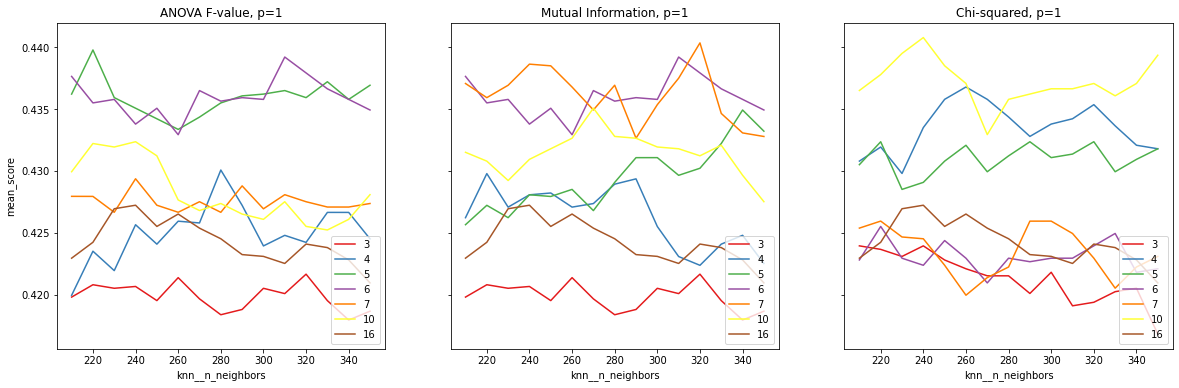

In [ ]:
plot_KNN_results(results_KNN2)

This time around, the top 10 features were selected by the Mutual Info (and ANOVA F-value) method and is used by our KNN model to find its 240 nearest neighbours at a p of 1 with a mean accuracy score of 0.4443.

This is a minor improvement when compared with the best mean score of 0.4408 from the last run. The graphs above show that many of the lines have either levelled out or begun to decline.

Decision Trees (DT)

Here we will build a decision tree that uses the Gini index to split the data. We will use GridSearchCV to determine the optimal values for the maximum depth and minimum sample split.

DT hyperparameters include:

The maximum depth of the DT, where we will initially consider the values 5, 7 and 9.

The minimum number of samples required to be at a leaf node, where we will initially consider the values 2, 3, 5, 7, 9, 11.

In [ ]:
def run_dt_pipe(max_depth, min_split):
    pipe_DT = Pipeline([('selector', SelectKBest()), 
                         ('dt', DecisionTreeClassifier(criterion='gini'))])

    params_pipe_DT = {'selector__score_func': [f_classif, mutual_info_classif, chi2], 'selector__k': [3, 4, 5, 6, 7, 10, df_norm.shape[1]], 'dt__max_depth': max_depth, 'dt__min_samples_split': min_split}
 
    gs_pipe_DT = GridSearchCV(estimator=pipe_DT, param_grid=params_pipe_DT, cv=cv, n_jobs = -1, scoring='accuracy', verbose=0)

    gs_pipe_DT.fit(df_train, leagues_train);
    
    return gs_pipe_DT


gs_pipe_DT = run_dt_pipe([5, 7, 9], [2, 3, 5, 7, 9, 11])

In [ ]:
gs_pipe_DT.best_params_

{'dt__max_depth': 5,
 'dt__min_samples_split': 5,
 'selector__k': 5,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif>}

In [ ]:
gs_pipe_DT.best_score_

0.4142395236613652

The top 7 features were selected by the Chi-squared test and is used with a maximum depth of 5 and minimum split value of 2. The output shows that this optimal DT model has a mean accuracy score of 0.4174.

In [ ]:
results_DT = get_search_results(gs_pipe_DT)
results_DT.head(5)

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,selector__k,selector__score_func
48,0.41424,0.0186847,0.449679,0.38758,5,5,5,<function f_classif at 0x7f5327e56e60>
6,0.414097,0.0188625,0.45182,0.38758,5,2,5,<function f_classif at 0x7f5327e56e60>
55,0.413955,0.0221149,0.462527,0.379015,5,5,7,<function mutual_info_classif at 0x7f5324fdab00>
90,0.413955,0.0186455,0.449679,0.386752,5,9,5,<function f_classif at 0x7f5327e56e60>
111,0.413955,0.0186455,0.449679,0.386752,5,11,5,<function f_classif at 0x7f5327e56e60>


As we did before, we will plot these expected results to get an understanding of how changing the hyperparameters affect the prediction accuracy.

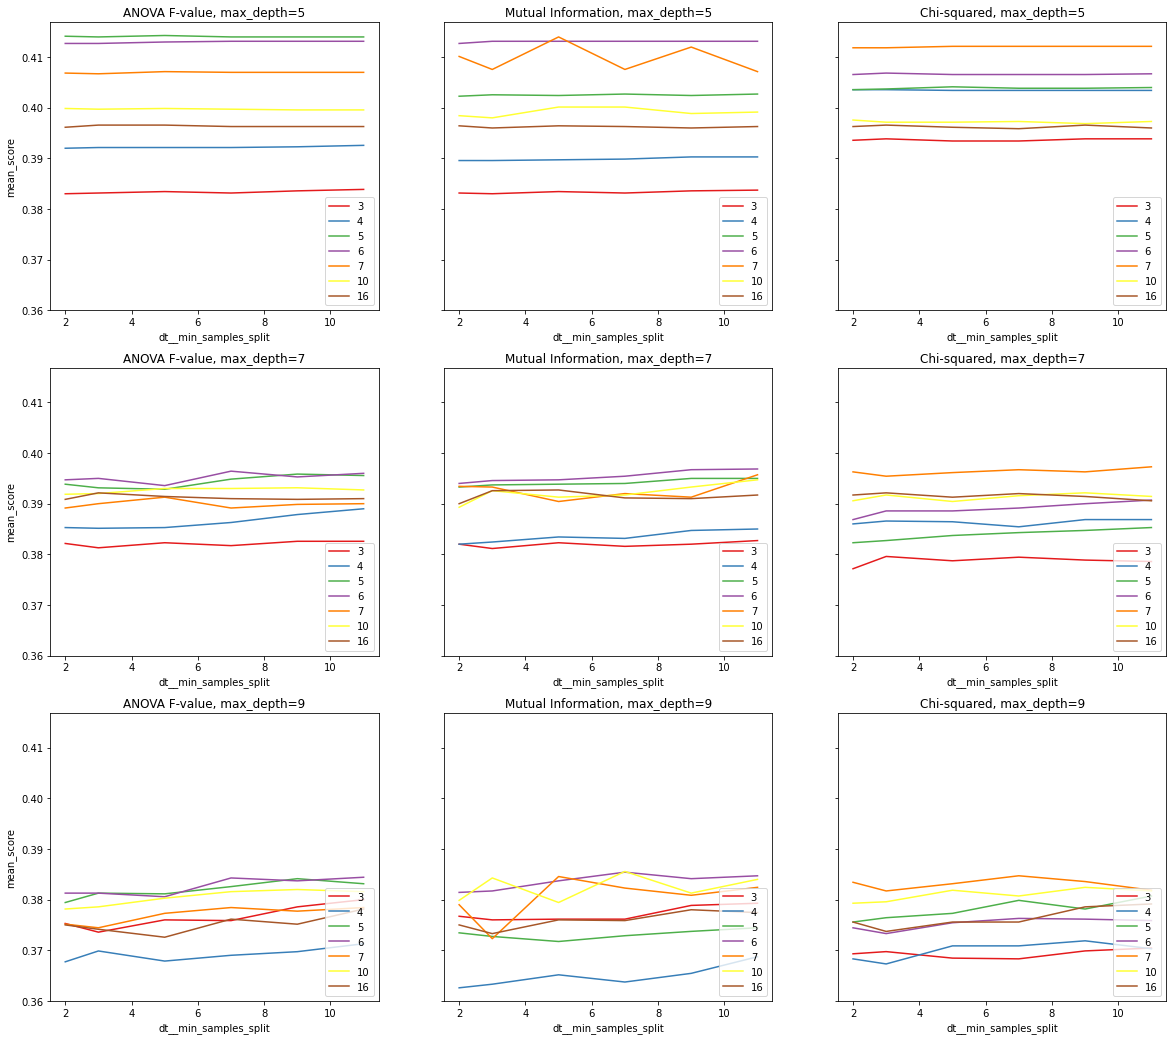

In [ ]:
def plot_DT_results(res):
    def get_selector_data(d, p, sel):
        return d[(d.dt__max_depth==p) & (d.selector__score_func==sel)].iloc[:,[0,5,6]]
    
    rows = len(res["dt__max_depth"].unique())
    
    fig, axs = plt.subplots(ncols=3, nrows=rows, figsize=(20,rows*6), sharey='all')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
    titles = []
    data = []
    temp = res.copy().infer_objects()
    for i, p in enumerate(res["dt__max_depth"].unique()):
        titles.append(f"ANOVA F-value, max_depth={p}")
        data.append(get_selector_data(temp, p, f_classif))
        titles.append(f"Mutual Information, max_depth={p}")
        data.append(get_selector_data(temp, p, mutual_info_classif))
        titles.append(f"Chi-squared, max_depth={p}")
        data.append(get_selector_data(temp, p, chi2))
    
    row = 0
    col = 0
    ax = None
    for i in range(rows*3):
        if col%3==0 and col!=0:
            col=0
            row+=1
        if rows == 1:
            ax = axs[col]
        else:
            ax=axs[row,col]
        p = sns.lineplot(x='dt__min_samples_split', 
                         y='mean_score', 
                         hue='selector__k', 
                         data=data[i], 
                         ax=ax, 
                         palette=sns.color_palette("Set1", 7))
        p.set_title(titles[i])
        p.legend(loc='lower right')
        col+=1

plot_DT_results(results_DT)

Fine Tuning DT
There is a very clear downward trend for the mean score as the max depth increases. Thus the next step would be to rerun the model with depths that are less than 5. After that, we will also increase the values that are being checked for min_samples_split to check for better values.

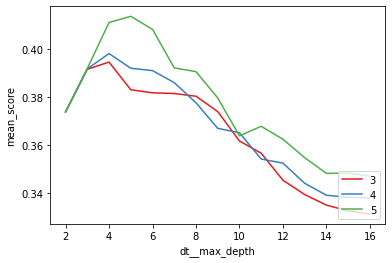

In [ ]:
def compare_depths():
    def get_selector_data(d, p, sel):
        return d[(d.dt__min_samples_split==p) & (d.selector__score_func==sel)].iloc[:,[0,4,6]]
    
    pipe_DT = Pipeline([('selector', SelectKBest()), 
                         ('dt', DecisionTreeClassifier(criterion='gini'))])

    params_pipe_DT = {'selector__score_func': [f_classif],
                       'selector__k': [3, 4, 5],
                       'dt__max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
                       'dt__min_samples_split': [2]}
 
    gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                               param_grid=params_pipe_DT, 
                               cv=cv,
                               n_jobs = -1,
                               scoring='accuracy',
                               verbose=0)

    res = get_search_results(gs_pipe_DT.fit(df_train, leagues_train));
    res = res.infer_objects()
    p = sns.lineplot(x='dt__max_depth', 
                     y='mean_score', 
                     hue='selector__k', 
                     data=get_selector_data(res,2,f_classif), 
                     palette=sns.color_palette("Set1", 3))
    #p.set_title(titles[i])
    p.legend(loc='lower right')
    
compare_depths()

We can see that the value 5 for maximum depth is clearly the optimal one.

Next, we will try many different values for minimum sample splitting threshold. We are able to do so many as locking down the depth frees up the computing time.

In [ ]:
gs_pipe_DT2 = run_dt_pipe([5], [11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201])
gs_pipe_DT2.best_params_

{'dt__max_depth': 5,
 'dt__min_samples_split': 151,
 'selector__k': 5,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif>}

In [51]:
gs_pipe_DT2.best_score_

0.42122964671144547

In [52]:
results_DT2 = get_search_results(gs_pipe_DT2)
results_DT2.head(5)

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,selector__k,selector__score_func
300,0.42123,0.02134,0.458244,0.379015,5,151,5,<function f_classif at 0x7f5327e56e60>
342,0.420944,0.0219645,0.461538,0.383298,5,171,5,<function f_classif at 0x7f5327e56e60>
279,0.420373,0.0219642,0.458244,0.379015,5,141,5,<function f_classif at 0x7f5327e56e60>
321,0.42023,0.0228645,0.461538,0.379015,5,161,5,<function f_classif at 0x7f5327e56e60>
258,0.420089,0.0205925,0.458244,0.383298,5,131,5,<function f_classif at 0x7f5327e56e60>


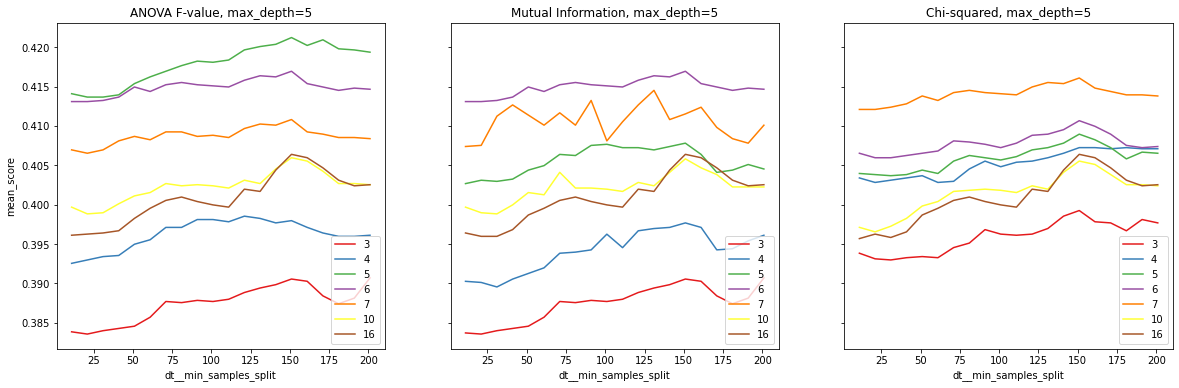

In [53]:
plot_DT_results(results_DT2)

Similar to before, the top 3 features were selected by the Chi-squared test and is used in conjunction with max_depth=5 and min_samples_split=181 to obtain a mean accuracy score of 0.4187.

This is a minor improvement when compared with the best mean score of 0.4174 from the last run. The graphs above show that it is unlikely we will find a better value by increasing the value of min_samples_split as there is a steep decline at around 161.

Naive Bayes (NB)

Here we will build a Gaussian Naive Bayes model and optimize the value of var_smoothing. We will perform a logspace search for the optimal var_smoothing, starting with the 100 to  10−2  with a total of 100 values. There is no prior information available to provide this model.

Each descriptive feature must follow a Gaussian distribution in a NB model, a power transformation is first performed on the input data.

Because the Chi-sqaured test does not work with negative values, it will be excluded from the pipeline of this section.

In [56]:
np.random.seed(1)

def run_NB_pipe(var_smoothing):
    pipe_NB = Pipeline([('selector', SelectKBest()), ('nb', GaussianNB())])

    params_pipe_NB = {'selector__score_func': [f_classif, mutual_info_classif], 'selector__k': [3, 4, 5, 6, 7, 10, df_norm.shape[1]], 'nb__var_smoothing': var_smoothing}

    gs_pipe_NB = GridSearchCV(estimator=pipe_NB, param_grid=params_pipe_NB, cv=cv, n_jobs = -1, scoring='accuracy', verbose=0)
    
    df_train_transformed = PowerTransformer().fit_transform(df_train)
    gs_pipe_NB.fit(df_train_transformed, leagues_train);
    
    return gs_pipe_NB


gs_pipe_NB = run_NB_pipe(np.logspace(2,-2, num=100))
gs_pipe_NB.best_params_

{'nb__var_smoothing': 0.014508287784959387,
 'selector__k': 10,
 'selector__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif>}

In [57]:
gs_pipe_NB.best_score_

0.4596115717100728

The top 10 features were selected by the Mutual Info selector and using var_smoothing=0.16297508346206435, our model obtains a mean score of 0.4603.

In [58]:
results_NB = get_search_results(gs_pipe_NB)
results_NB.head(5)

,mean_score,std_score,max_score,min_score,nb__var_smoothing,selector__k,selector__score_func
1341,0.459612,0.0177569,0.498929,0.436831,0.0145083,10,<function mutual_info_classif at 0x7f5324fdab00>
1397,0.459329,0.0170302,0.498929,0.436831,0.01,10,<function mutual_info_classif at 0x7f5324fdab00>
1145,0.459184,0.0194726,0.501071,0.426124,0.053367,10,<function mutual_info_classif at 0x7f5324fdab00>
991,0.4589,0.0192143,0.49359,0.432548,0.148497,10,<function mutual_info_classif at 0x7f5324fdab00>
921,0.458899,0.016268,0.490364,0.438972,0.236449,10,<function mutual_info_classif at 0x7f5324fdab00>


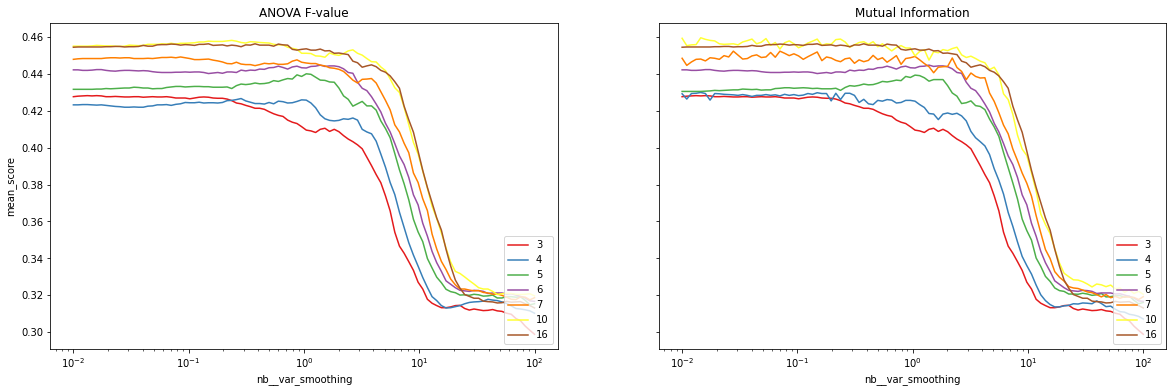

In [59]:
def plot_NB_results(res):
    def get_selector_data(d, sel):
        return d[(d.selector__score_func==sel)].iloc[:,[0,4,5]]
    
    fig, axs = plt.subplots(ncols=2, figsize=(20,6), sharey='all')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
    
    titles = []
    data = []
    temp = res.copy().infer_objects()
    
    titles.append(f"ANOVA F-value")
    data.append(get_selector_data(temp, f_classif))
    titles.append(f"Mutual Information")
    data.append(get_selector_data(temp, mutual_info_classif))
    
    for i in range(2):
        p = sns.lineplot(x='nb__var_smoothing', y='mean_score', hue='selector__k', data=data[i], ax=axs[i], palette=sns.color_palette("Set1", 7))
        p.set_xscale("log")
        p.set_title(titles[i])
        p.legend(loc='lower right')

plot_NB_results(results_NB)

As there doesn't seem to be any pattern pointing to values of var_smoothing improving the mean score, there won't be any fine tuning done for this model.

Performance Comparison 

Now that we have created our optimized models for each classifier, we will use them on the test data with 10 fold repeated cross-validation. Due to the randomness of the cross-validation process, any differences in performance of the optimized models will be put through pairwise t-tests to determine if they are statistically significant.

First, we will calculate the cross-validation scores for each of our models.

In [60]:
cv2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2)

cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN2.best_estimator_, X=df_test, y=leagues_test, cv=cv2, n_jobs=-1, scoring='accuracy')
cv_results_KNN.mean()

0.41989768976897696

In [61]:
cv_results_DT = cross_val_score(estimator=gs_pipe_DT2.best_estimator_, X=df_test, y=leagues_test, cv=cv2, n_jobs=-1, scoring='accuracy')
cv_results_DT.mean()

0.3948778877887789

In [62]:
df_test_transformed = PowerTransformer().fit_transform(df_test)

cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_, X=df_test_transformed, y=leagues_test, cv=cv2, n_jobs=-1, scoring='accuracy')
cv_results_NB.mean()

0.4332013201320132

Second, we conduct a paired t-test for the accuracy score between the following model combinations:

KNN vs. DT

KNN vs. NB

DT vs. NB

In [63]:
print(stats.ttest_rel(cv_results_KNN, cv_results_DT))
print(stats.ttest_rel(cv_results_KNN, cv_results_NB))
print(stats.ttest_rel(cv_results_DT, cv_results_NB))

Ttest_relResult(statistic=2.6573627632491266, pvalue=0.012674416188678822)
Ttest_relResult(statistic=-1.6280178845937698, pvalue=0.11433859519407741)
Ttest_relResult(statistic=-3.3339761867335076, pvalue=0.002351054642785671)


Looking at these results, we conclude that at a 95% significance level, NB is statistically the best model in terms of accuracy when compared on the test data.

We will now compare the models using other measures such as:

Precision

Recall

F1 Score (the harmonic average of precision and recall)

Confusion Matrix

In [64]:
pred_KNN = gs_pipe_KNN.predict(df_test)

pred_DT = gs_pipe_DT2.predict(df_test)

df_test_transformed = PowerTransformer().fit_transform(df_test)
pred_NB = gs_pipe_NB.predict(df_test_transformed)

print("\nK-Nearest Neighbour Report") 
print(metrics.classification_report(leagues_test, pred_KNN))
print("\nDecision Tree Report") 
print(metrics.classification_report(leagues_test, pred_DT))
print("\nNaive Bayes Report") 
print(metrics.classification_report(leagues_test, pred_NB))


K-Nearest Neighbour Report
              precision    recall  f1-score   support

           1       0.48      0.56      0.52       154
           2       0.27      0.19      0.22       166
           3       0.35      0.45      0.39       244
           4       0.38      0.39      0.39       241
           5       0.62      0.46      0.52       197

    accuracy                           0.41      1002
   macro avg       0.42      0.41      0.41      1002
weighted avg       0.42      0.41      0.41      1002


Decision Tree Report
              precision    recall  f1-score   support

           1       0.43      0.54      0.48       154
           2       0.27      0.15      0.19       166
           3       0.36      0.48      0.41       244
           4       0.37      0.29      0.32       241
           5       0.56      0.59      0.57       197

    accuracy                           0.41      1002
   macro avg       0.40      0.41      0.40      1002
weighted avg       0.40    

In [65]:
print("\nConfusion matrix for K-Nearest Neighbour") 
print(metrics.confusion_matrix(leagues_test, pred_KNN))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(leagues_test, pred_DT))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(leagues_test, pred_NB))


Confusion matrix for K-Nearest Neighbour
[[ 87  32  30   5   0]
 [ 54  31  58  22   1]
 [ 36  35 109  49  15]
 [  3  14  89  95  40]
 [  0   3  25  79  90]]

Confusion matrix for Decision Tree
[[ 83  31  35   5   0]
 [ 56  25  60  19   6]
 [ 40  24 116  42  22]
 [ 11  10  88  69  63]
 [  1   2  27  51 116]]

Confusion matrix for Naive Bayes
[[101  33  15   4   1]
 [ 61  28  47  26   4]
 [ 39  40  86  54  25]
 [  6  18  69  71  77]
 [  0   0  21  43 133]]


Conclusion

The F-value selector selected the 7 best features which were used to create a Decision Tree (DT) model that obtained the highest cross-validated Accuracy score on the training data. Although on average the DT model model on average does not outperform the Naive Bayes and k-Nearest Neighbours (KNN) models, it is the most balanced model with the smallest range for all of its classification measures.

With a mean training score of 0.4187 and 0.4034 on the test data, the model's performance is not good. However, it does provide better chance of success than purely guessing placement in 5 categories.